In [1]:
import os
# os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
# import geopandas as gpd
from tqdm.notebook import tqdm
import yaml

In [2]:
import glob

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Configuration

In [4]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
path_out = Path(cfg['path_out'])
if path_out.exists() is False:
    path_out.mkdir()
var = cfg['var']

### Coordinates

In [5]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
ids = ids[~np.isnan(ids) & (ids != -9999)]
ids = ids.astype(int)

In [13]:
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids}, name='lon')
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids}, name='lat')
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

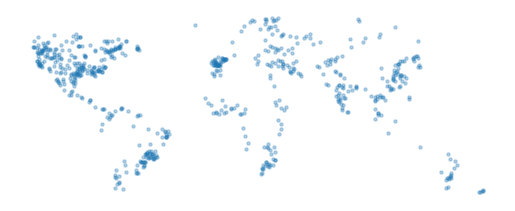

In [7]:
# plot reservoir locations
fig, ax = plt.subplots()
ax.scatter(lon.data, lat.data, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### Time series of reservoir storage

In [9]:
for file in tqdm(glob.glob(f'{path_ts}/{var}_20[12]?.nc')):
    
    # check if the data was already processed
    filename = file.split('\\')[-1]
    fileout = path_out / filename.replace('.nc', f'_extract{len(ids)}.nc')
    if (fileout).exists():
        continue
        
    # open the dataset lazily using dask
    da = xr.open_dataset(file, chunks='auto')[var]
    
    # extract data for the reservoirs
    da = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat'])
    
    # export extraction
    da.to_netcdf(fileout)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
# parameter = "dis24"
# filepath = "CDS_GloFASv40_reanalysis/"

# for year in np.arange(1980,1981):

#     yearstring = str(year)
    
#     # load GRIB file
#     fullfilepath = filepath + yearstring + '.grib'
#     ds = xr.open_dataset(fullfilepath, engine="cfgrib", backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface"}}, chunks={"time": 1})
    
#     # load table of points
#     df = pd.read_csv("GRDC.csv")
#     total = len(df) # number of points
    
#     # extract time series for each point
#     allIDs = []
#     rows_time = []
#     rows_value = []
#     count = 0
#     for lon, lat, id in zip(df.LisfloodX, df.LisfloodY, df.grdc_no):
        
#         extracted = ds.sel(longitude=lon, latitude=lat, method="nearest")[parameter]
#         print(extracted)
#         df_time = extracted.indexes
#         df_values = extracted.values
#         print("timing 1")
#         print("timing 2")
#         rows_time.append(df_time._indexes['time'].values[:])
#         rows_value.append(df_values)
#         print("timing 3")
#         count += 1
#         print(f"progress: {count/total*100} %")

#         allIDs.append(id)

      
#     # save time series as CSV
#     savefilename = "extracted_test_" + yearstring + ".csv"
#     with open(savefilename, "w") as f:
#         # header
#         f.write("id\ttime\tvalue\n")
#         # time series of each point
#         for id, time, value in zip(allIDs, rows_time, rows_value):
#             for t, v in zip(time,value):
#                 f.write(f"{id}\t{t}\t{v}\n")